# Neural Style Transfer: Results evaluation

## Initial settings

In [12]:
%%capture
! pip install tensorflow_hub --upgrade

In [4]:
import json
import datetime
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
from PIL import Image
import re
import os
import numpy as np
import pandas as pd
from collections import defaultdict 
import seaborn as sns

INPUT_LOCAL_PATH = './data/input'
INPUT_CONTENT_PATH = f'{INPUT_LOCAL_PATH}/content-images'
INPUT_STYLE_PATH = f'{INPUT_LOCAL_PATH}/style-images'

OUTPUT_LOCAL_PATH = './data/output'
OUTPUT_DOWNLOADS_PATH = f'{OUTPUT_LOCAL_PATH}/model-downloads'
OUTPUT_RESULTS_PATH = f'{OUTPUT_LOCAL_PATH}/model-results'
OUTPUT_FAST_TRANSFER_PATH = f'{OUTPUT_LOCAL_PATH}/fast-style-transfer'
OUTPUT_FINAL_RESULTS_PATH = f'{OUTPUT_LOCAL_PATH}/final-results'

OUTPUT_BUCKET = 's3://sagemaker-studio-sr1encmpcxc/output'

METADATA_LOCAL_PATH = './estimators_metadata'

## Load estimators metadata

In [5]:
  def load_estimators_metadata(estimator_names: list[str]) -> list[dict[str, str]]:
    estimators_metadata = []
    for name in estimator_names:
        hyperparams = load_estimator_hyperparams(name)
        metadata = get_estimators_metadata(hyperparams)
        estimators_metadata.append(metadata)
    return estimators_metadata
        
def load_estimator_hyperparams(estimator_name: str) -> dict[str, str]:
    hyperparams_path = f'{METADATA_LOCAL_PATH}/{estimator_name}.json'
    with open(hyperparams_path, "r") as f:
        hyperparams = json.load(f)
    return hyperparams

def get_estimators_metadata(estimator_hyperparams: dict[str, str]) -> dict[str, str]:
    
    estimator_metadata = {}
    
    content_img_name = eval(estimator_hyperparams['content_image'])
    style_img_name = eval(estimator_hyperparams['style_image'])
    estimator_name = eval(estimator_hyperparams['sagemaker_job_name'])
    output_images_dir = f'{OUTPUT_DOWNLOADS_PATH}/{estimator_name}'
    num_iterations =  eval(estimator_hyperparams['num_iter'])
    
    estimator_metadata['estimator_name'] = estimator_name
    estimator_metadata['content_img_name'] = content_img_name
    estimator_metadata['style_img_name'] = style_img_name
    estimator_metadata['output_images_dir'] = output_images_dir
    estimator_metadata['content_image_path'] = f'{INPUT_CONTENT_PATH}/{content_img_name}'
    estimator_metadata['style_image_path'] = f'{INPUT_STYLE_PATH}/{style_img_name}'
    estimator_metadata['output_image_path'] = final_image_path(output_images_dir, num_iterations)
    
    return estimator_metadata


def final_image_path(output_images_dir: str, num_iter: int) -> str:
    return f'{output_images_dir}/result-iter-{num_iter - 1}.jpg'

In [6]:
estimator_names = [
    'pytorch-style-transfer22-2023-04-15-12-05-46-107',
    'pytorch-style-transfer22-2023-04-15-12-05-45-086',
    'pytorch-style-transfer22-2023-04-15-12-05-44-512',
    'pytorch-style-transfer22-2023-04-15-12-05-37-456',
    'pytorch-style-transfer22-2023-04-15-12-05-36-695',
    'pytorch-style-transfer22-2023-04-15-11-38-34-217',
    'pytorch-style-transfer22-2023-04-15-11-09-09-503',
    'pytorch-style-transfer22-2023-04-15-11-09-08-256',
    'pytorch-style-transfer22-2023-04-15-11-09-07-688',
    'pytorch-style-transfer22-2023-04-15-11-09-06-670',
    'pytorch-style-transfer22-2023-04-15-11-09-05-115',
    'pytorch-style-transfer22-2023-04-15-11-09-04-198',
    'pytorch-style-transfer22-2023-04-15-11-09-03-496',
    'pytorch-style-transfer22-2023-04-15-11-09-01-111',
    'pytorch-style-transfer22-2023-04-14-15-47-41-819',
    'pytorch-style-transfer22-2023-04-15-12-05-46-909',
]
estimators_metadata = load_estimators_metadata(estimator_names)

##### Dummy estimators metadata (used for testing)

In [5]:
# estimators_hyperparams = [
#      {'content_image': '"sphynx_cat.jpg"',
#       'style_image': '"adele_block_from_klimt.jpg"',
#       'num_steps': '300',
#       'num_iter': '4',
#       'sagemaker_submit_directory': '"s3://sagemaker-studio-sr1encmpcxc/pytorch-style-transfer22-2023-04-11-07-53-03-342/source/sourcedir.tar.gz"',
#       'sagemaker_program': '"style_transfer_pytorch.py"',
#       'sagemaker_container_log_level': '20',
#       'sagemaker_job_name': '"pytorch-style-transfer22-2023-04-11-07-53-03-342"',
#       'sagemaker_region': '"us-east-1"'},
#      {'content_image': '"sphynx_cat.jpg"',
#       'style_image': '"Vassily_Kandinsky.jpeg"',
#       'num_steps': '300',
#       'num_iter': '4',
#       'sagemaker_submit_directory': '"s3://sagemaker-studio-sr1encmpcxc/pytorch-style-transfer22-2023-04-11-09-06-19-859/source/sourcedir.tar.gz"',
#       'sagemaker_program': '"style_transfer_pytorch.py"',
#       'sagemaker_container_log_level': '20',
#       'sagemaker_job_name': '"pytorch-style-transfer22-2023-04-11-09-06-19-859"',
#       'sagemaker_region': '"us-east-1"'}
# ]

# estimators_metadata = list(map(get_estimators_metadata, estimators_hyperparams))

## Visualize Content - Style - Generated image

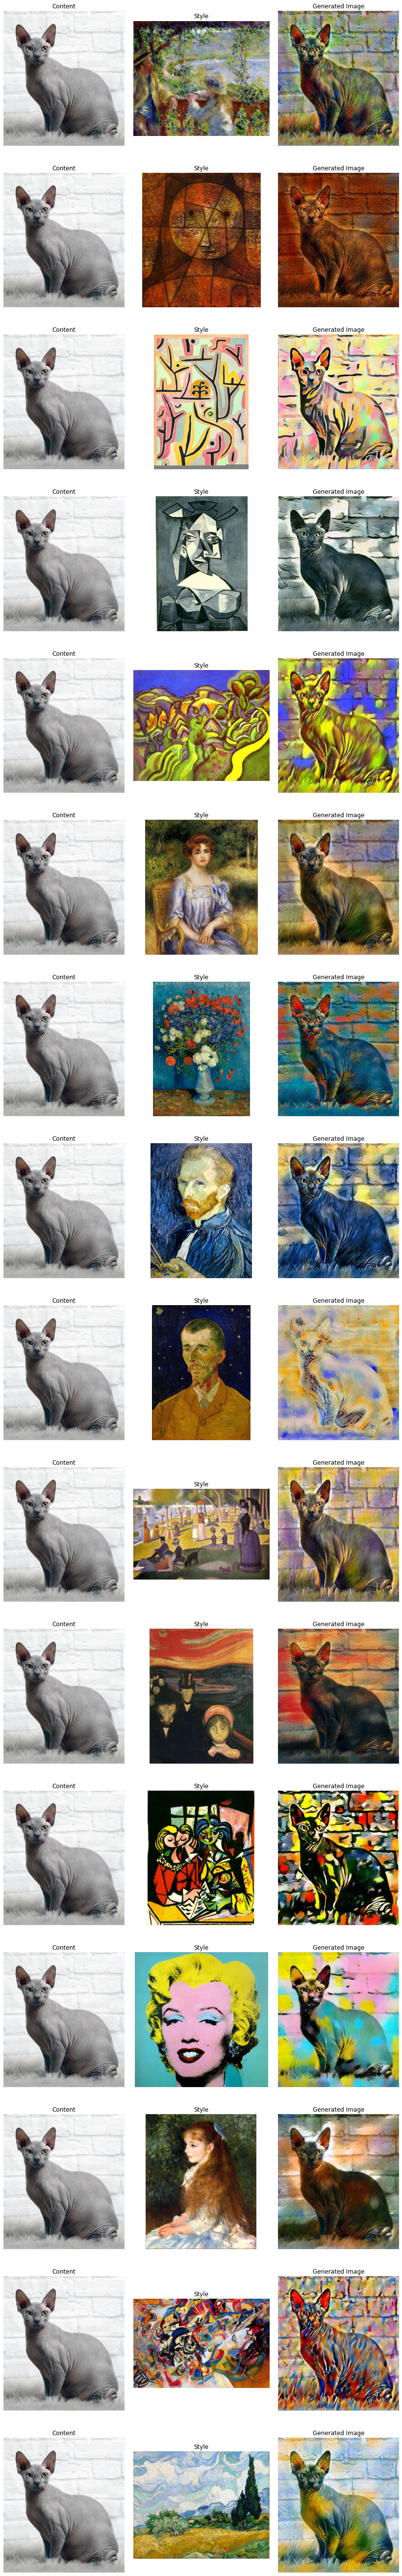

In [7]:
def load_style_transfer_images(estimators_metadata):
    
    nrows = len(estimators_metadata) 
    ncols = 3
    fig, axs = plt.subplots(nrows, ncols,  figsize=(15, 6*nrows))
    fig.subplots_adjust(wspace=0.05)
    for metadata, axes in zip(estimators_metadata, axs):

        # Define input paths for the images
        content_image_path = metadata['content_image_path']
        style_image_path = metadata['style_image_path']
        output_image_path = metadata['output_image_path']

        # Load images
        images = [
            ('Content', Image.open(content_image_path)),
            ('Style', Image.open(style_image_path)),
            ('Generated Image', Image.open(output_image_path))
        ]

        # Plot images
        for (img_type, img_data), ax in zip(images, axes):
            ax.imshow(img_data)
            ax.axis('off')
            ax.set_title(img_type)
    
    fig.subplots_adjust(wspace=0.01)
    fig.savefig(f'{OUTPUT_FINAL_RESULTS_PATH}/neural-style-transfer.jpg', dpi=100, bbox_inches='tight')

    
load_style_transfer_images(estimators_metadata)

## Visualize Neural Transfer Style Image vs Fast Transfer Style Image

In [11]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [12]:
def load_img(path_to_img):
      """
      Loads an image from a file path and returns a tensor of shape (1, height, width, channels)
      with pixel values scaled to the range [0, 1].
      The input image size is limited to a manageable size that can be processed efficiently by the model
      """
      img = tf.io.read_file(path_to_img)
      img = tf.image.decode_image(img, channels=3)

      # Convert pixel values to `float32` and scale values to range [0, 1]
      img = tf.image.convert_image_dtype(img, tf.float32) 

      # Set max. dimension (either width or height)
      max_dim = 512 

      # Resize image preserving aspect ratio
      shape = tf.cast(tf.shape(img)[:-1], tf.float32)
      long_dim = max(shape)
      scale = max_dim / long_dim  
      new_shape = tf.cast(shape * scale, tf.int32)
      img = tf.image.resize(img, new_shape) 

      # Add extra dimension to the tensor (batch size)
      img = img[tf.newaxis, :]
      return img

def tensor_to_image(tensor):
      """Convert tensor to image.
      PIL (Python Imaging Library) expects the pixel values in an image to be represented as
      unsigned 8-bit integers with values between 0 and 255
      """
      # Convert pixel values in the tensor to the range [0,255]
      tensor = tensor*255
      # Convert to a numpy array with unsigned 8-bit integers
      tensor = np.array(tensor, dtype=np.uint8)

      # If the tensor has a batch dimension, remove it
      if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]

      return Image.fromarray(tensor)

In [13]:
def load_fast_transfer_image(estimator_metadata) -> str:
    """Loads the Fast Style Transfer image corresponding to an estimator.
    If the image does not exist, it is created and saved.
    """
    
    # Define output path for the fast transfer image
    content_img_name = estimator_metadata['content_img_name'] 
    style_img_name = estimator_metadata['style_img_name'] 
    image_name = fast_transfer_image_name(content_img_name, style_img_name)
    output_image_path = f'{OUTPUT_FAST_TRANSFER_PATH}/{image_name}'

    # If the image does not exist, create it
    if  not os.path.isfile(output_image_path):

        # Create stylized image with TF HUB
        content_image = load_img(estimator_metadata['content_image_path'] )
        style_image= load_img(estimator_metadata['style_image_path'] )
        stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

        # Save image
        tensor_to_image(stylized_image) .save(output_image_path)

    return output_image_path

def fast_transfer_image_name(content_img_name: str, style_img_name: str):
    content_img_name = re.sub(r'[^a-zA-Z0-9]', '', content_img_name)
    style_img_name = re.sub(r'[^a-zA-Z0-9]', '', style_img_name)
    return f'{content_img_name}_and_{style_img_name}.jpg'

In [ ]:
def compare_style_transfer_images(estimators_metadata):
    
    nrows = len(estimators_metadata) 
    ncols = 4
    fig, axs = plt.subplots(nrows, ncols,  figsize=(20, 6*nrows))
    fig.subplots_adjust(wspace=0.05)
    for metadata, axes in zip(estimators_metadata, axs):
    
        # Define input paths for the images
        content_image_path = metadata['content_image_path']
        style_image_path = metadata['style_image_path']
        output_image_path = metadata['output_image_path'] 
        fast_transfer_image_path = load_fast_transfer_image(metadata)

        # Load images to plot
        images = [
            ('Content', Image.open(content_image_path)),
            ('Style', Image.open(style_image_path)),
            ('Neural Style Transfer', Image.open(output_image_path)),
            ('Fast Style Transfer', Image.open(fast_transfer_image_path))
        ]

        # Plot images
        for (img_type, img_data), ax in zip(images, axes):
            ax.imshow(img_data)
            ax.axis('off')
            ax.set_title(img_type)
    
    fig.subplots_adjust(wspace=0.01)
    fig.savefig(f'{OUTPUT_FINAL_RESULTS_PATH}/neural-vs-fast.jpg', dpi=100, bbox_inches='tight')
    

compare_style_transfer_images(estimators_metadata)

## Create image quality metrics (Fast vs Neural)

In [17]:
def calculate_mse(content_image, stylized_image):
    content_shape = (content_image.shape[1], content_image.shape[2])
    stylized_image_resized = tf.image.resize(stylized_image, content_shape)

    return tf.add_n([tf.reduce_mean((stylized_image_resized-content_image)**2)]).numpy()


def calculate_ssim(content_image, stylized_image):
    content_shape = (content_image.shape[1], content_image.shape[2])
    stylized_image_resized = tf.image.resize(stylized_image, content_shape)

    return tf.image.ssim(content_image, stylized_image_resized, max_val=1).numpy()[0]


def produce_metrics_results(estimators_metadata):
    
    metrics = defaultdict(list)
    
    for metadata in estimators_metadata:
        
        estimator_name = metadata['estimator_name']
        content_image_path = metadata['content_image_path']
        output_image_path = metadata['output_image_path']
        fast_transfer_image_path = load_fast_transfer_image(metadata)
        
        # Load images to compare
        images = {
            'Content': load_img(content_image_path),
            'Neural Style': load_img(output_image_path),
            'Fast Style': load_img(fast_transfer_image_path)
        }
        

        metrics['estimator_name'].append(estimator_name)
        metrics['MSE_Neural_Style'].append(
            calculate_mse(images['Content'], images['Neural Style'])
        )
        metrics['MSE_Fast_Style'].append(
            calculate_mse(images['Content'], images['Fast Style'])
        )
        metrics['SSIM_Neural_Style'].append(
            calculate_ssim(images['Content'], images['Neural Style'])
        )
        metrics['SSIM_Fast_Style'].append(
            calculate_ssim(images['Content'], images['Fast Style'])
        )
    
    return pd.DataFrame(metrics)
        
metrics_df = produce_metrics_results(estimators_metadata*5)        
metrics_df

estimator_name  MSE_Neural_Style  \
0   pytorch-style-transfer22-2023-04-15-12-05-46-107          0.106305   
1   pytorch-style-transfer22-2023-04-15-12-05-45-086          0.300491   
2   pytorch-style-transfer22-2023-04-15-12-05-44-512          0.053958   
3   pytorch-style-transfer22-2023-04-15-12-05-37-456          0.102437   
4   pytorch-style-transfer22-2023-04-15-12-05-36-695          0.146739   
..                                               ...               ...   
75  pytorch-style-transfer22-2023-04-15-11-09-04-198          0.236340   
76  pytorch-style-transfer22-2023-04-15-11-09-03-496          0.077290   
77  pytorch-style-transfer22-2023-04-15-11-09-01-111          0.143008   
78  pytorch-style-transfer22-2023-04-14-15-47-41-819          0.101594   
79  pytorch-style-transfer22-2023-04-15-12-05-46-909          0.036896   

    MSE_Fast_Style  SSIM_Neural_Style  SSIM_Fast_Style  
0         0.106377           0.576691         0.402843  
1         0.200724           0.393305         0.326326  
2         0.086318           0.545094         0.309803  
3         0.112154           0.521707         0.385062  
4         0.113800           0.500204         0.370390  
..             ...                ...              ...  
75        0.208691           0.229467         0.234090  
76        0.073842           0.662898         0.540600  
77        0.132671           0.588038         0.517596  
78        0.133048           0.409040         0.270023  
79        0.051586           0.722366         0.495091  

[80 rows x 5 columns]

In [41]:
metrics_df['MSE_improvement'] = (metrics_df.MSE_Fast_Style -  metrics_df.MSE_Neural_Style)/metrics_df.MSE_Fast_Style * 100
metrics_df['SSIM_improvement'] = (metrics_df.SSIM_Neural_Style - metrics_df.SSIM_Fast_Style)/metrics_df.SSIM_Fast_Style * 100
metrics_df

estimator_name  MSE_Neural_Style  \
0   pytorch-style-transfer22-2023-04-15-12-05-46-107          0.106305   
1   pytorch-style-transfer22-2023-04-15-12-05-45-086          0.300491   
2   pytorch-style-transfer22-2023-04-15-12-05-44-512          0.053958   
3   pytorch-style-transfer22-2023-04-15-12-05-37-456          0.102437   
4   pytorch-style-transfer22-2023-04-15-12-05-36-695          0.146739   
..                                               ...               ...   
75  pytorch-style-transfer22-2023-04-15-11-09-04-198          0.236340   
76  pytorch-style-transfer22-2023-04-15-11-09-03-496          0.077290   
77  pytorch-style-transfer22-2023-04-15-11-09-01-111          0.143008   
78  pytorch-style-transfer22-2023-04-14-15-47-41-819          0.101594   
79  pytorch-style-transfer22-2023-04-15-12-05-46-909          0.036896   

    MSE_Fast_Style  SSIM_Neural_Style  SSIM_Fast_Style  MSE_improvement  \
0         0.106377           0.576691         0.402843         0.068533   
1         0.200724           0.393305         0.326326       -49.703903   
2         0.086318           0.545094         0.309803        37.489044   
3         0.112154           0.521707         0.385062         8.664034   
4         0.113800           0.500204         0.370390       -28.943941   
..             ...                ...              ...              ...   
75        0.208691           0.229467         0.234090       -13.248350   
76        0.073842           0.662898         0.540600        -4.669934   
77        0.132671           0.588038         0.517596        -7.791193   
78        0.133048           0.409040         0.270023        23.640860   
79        0.051586           0.722366         0.495091        28.475704   

    SSIM_improvement  
0          43.155525  
1          20.525009  
2          75.948761  
3          35.486706  
4          35.047871  
..               ...  
75         -1.974868  
76         22.622522  
77         13.609484  
78         51.483173  
79         45.905678  

[80 rows x 7 columns]

<ipython-input-61-fa4cf54a0082>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f"{tick}%\n" for tick in ax[0].get_yticks()])
<ipython-input-61-fa4cf54a0082>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f"{tick}%\n" for tick in ax[1].get_yticks()])


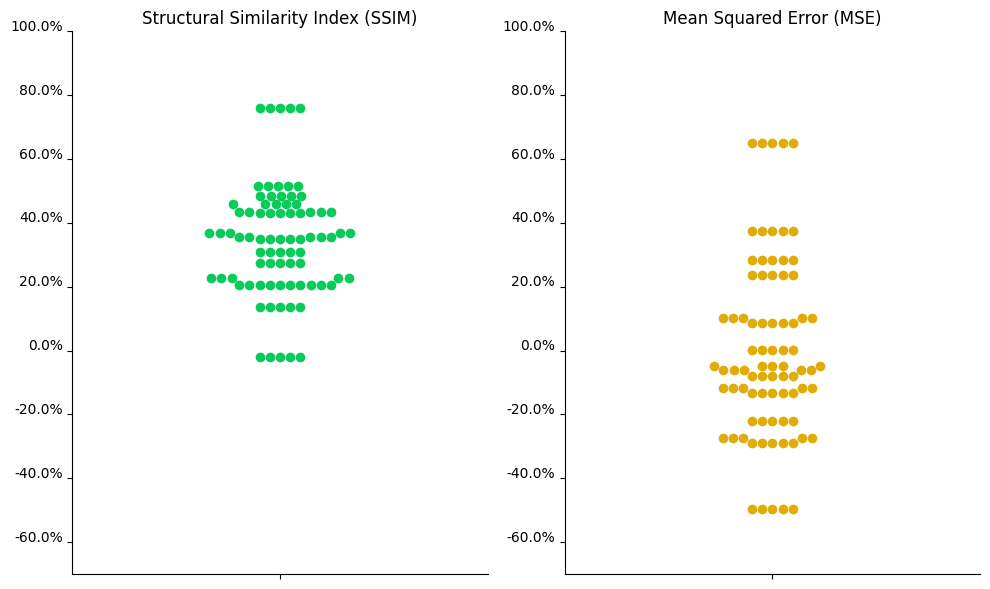

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=100)
sns.swarmplot(data=metrics_df, y='SSIM_improvement', size=7, ax=ax[0], color='#08CB59');
sns.swarmplot(data=metrics_df, y='MSE_improvement', size=7, ax=ax[1], color='#E1AB08');

# Config Y axes 
ax[0].set_ylabel(''), ax[1].set_ylabel('')
ax[0].set_ylim([-70, 100]), ax[1].set_ylim([-70, 100])
## Modify y-axis labels to add percentage symbol
ax[0].set_yticklabels([f"{tick}%\n" for tick in ax[0].get_yticks()])
ax[1].set_yticklabels([f"{tick}%\n" for tick in ax[1].get_yticks()])

# Config title
ax[0].set_title('Structural Similarity Index (SSIM)'), ax[1].set_title('Mean Squared Error (MSE)')

sns.despine(left=False, bottom=False)
plt.tight_layout()
